# STIR reconstruction using data simulated with SIMIND ###
This notebook lays out a simple simulation and reconstruction using SIMIND and STIR \
Please see Rebecca Gillen's instructions / presentation for a more in depth guide

### simind can be donwloaded from https://simind.blogg.lu.se/downloads/

There are reasonably straight forward instructions to be followed for Windows/Mac/Linux
### STIR can be downloaded from https://github.com/UCL/STIR
for the current development version that has the SPECT projection matrix exposed in python or 
### Latest stable release: https://stir.sourceforge.net/

To use jupyter notebooks with this file, make sure you specify your stir python path
e.g for Linux:

    ~$PYTHONPATH /usr/local/python jupyter notebook

In [1]:
### imports ###

# STIR modules
import stir
import stirextra

# Other modules
import numpy as np # STIR images & projection data can be exported as numpy arrays
import os
import subprocess
import matplotlib.pyplot as plt # for plotting

from pathlib import Path # for creating directories

import platform
current_os = platform.system().lower()

dir = os.path.abspath("") # current directory

In [2]:
# a useful function definition

def plot_show_save(image, fname, slice = False, save = False):
        ''' simple image plot and save function '''
        plt.subplot(111)
        if slice:
            plt.imshow(np.squeeze(stirextra.to_numpy(image))[slice])
        else:
            plt.imshow(np.squeeze(stirextra.to_numpy(image)))            
        plt.title(fname)
        plt.show()   
        if save:
            plt.savefig(fname)
            image.write_to_file('tmp_'+fname)


We are now ready to create our images. We'll use .par files in order to do this. SIMIND has some issues with switches (you'll see these later) getting confused with Linux directories so everything is currently in the same directory as the notebook.

The shell script creates images with .hv header files for STIR images, .smi header files for simind source images and .dmi header files for simind density maps.

We're currently having some issues with the simind attenuation, which we hope to fix soon so we'll only use the image in this simulation

In [19]:
help(stir.OSMAPOSLReconstruction3DFloat)

Help on class OSMAPOSLReconstruction3DFloat in module stir:

class OSMAPOSLReconstruction3DFloat(RPOSMAPOSLReconstruction3DFloat)
 |  Implementation of the Ordered Subsets version of Green's MAP One Step Late
 |  algorithm.  
 |  
 |  See Jacobson et al, PMB for a description of the implementation.  
 |  
 |  When no prior info is specified, this reduces to 'standard' OSEM.  
 |  
 |  Two different forms of the prior are implemented. (For background, see
 |  Mustavic&Thielemans, proc. IEEE MIC 2001).  
 |  
 |  When MAP_model == "additive" this implements the standard form of OSL (with a
 |  small modification for allowing subsets):  with $p_v = sum_b p_{bv}$.  
 |   actually, we restrict 1 + beta*prior_gradient/p_v between .1 and 10  
 |  
 |  On the other hand, when MAP_model == "multiplicative" it implements  with $p_v
 |  = sum_b p_{bv}$. actually, we restrict 1 + beta*prior_gradient between .1 and
 |  10.  
 |  
 |  Note that all this assumes 'balanced subsets', i.e.  
 |  
 |  \[

In [3]:
generate_data = os.path.join(Path(dir).parent.absolute(), 'scripts', 'generate_input_data.sh')
if Path(generate_data).exists():
    subprocess.run(["sh", generate_data, current_os])
else:
    print('generate_input_data.sh not found')

=== Using Linux directory structure
===  make emission image

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...
===  make attenuation image

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...

INFO: Processing next shape...
=== done


We'll now load this image file into a STIR object

In [4]:
image = stir.FloatVoxelsOnCartesianGrid.read_from_file("emission_image.hv") # example emission image 

And we have a simple image phantom

/home/sam/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sam/.local/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


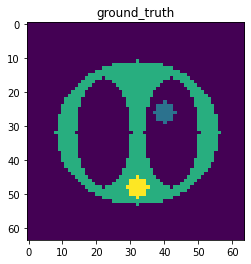

In [5]:
slice = image.get_lengths()[1]//2 # middle slice
plot_show_save(image, "ground_truth", slice = slice)

We're now ready to simulate our emission data. We have a .smc file containing information about the simulation. Please read the simind manual to learn about the many different options available. These options can be altered using either the change command (type "change input.smc into the terminal) or using switches \
The syntax for reconstruction is as follows:
`simind input_file_prefix outpute_files_prefix`
This can be followed by switches seperated by forward slashes such as below \*\
\* Unfortunately this causes some trible with Linux & MacOS file directories. The SIMIND manual claims that two backslashed '\\' can be used in place of a forward slash that is part of a file directory, but I haven't found this to be the case

The following bash command defines a .smc file `input.smc` follwed by a prefix for output files `output` \
Switches are then used to define:
* /NN: a multiplier for the number of histories per projection (which is calculated using the sum of all voxel values)
* /PX: defines the image pixel size in the i,j direction (transverse in this case) - im.voxel_sizes()
* /FS: defines the prefix for the .smi emission image file
* /FD: defines the prefix for rhe .dmi attenuation image file # note: we've simulated this without attenuation

In [6]:
src = os.path.join(Path(dir).parent.absolute(),"input_files")

In [7]:
for (root, dirs, files) in os.walk(src):
    for f in files:
        if not os.path.exists(os.path.join(dir,"symlink_"+f)):
            os.symlink(os.path.join(src,f), os.path.join(dir,"symlink_"+f))
            print("symlink @ " + os.path.join(src,"symlink_"+f))
        else: print("symlink already exists")

symlink already exists
symlink already exists
symlink already exists


In [8]:
%%bash
simind symlink_input output /NN:.01 /PX:0.4 /FS:emission_image.smi /FD:attenuation_image.dmi




              SIMIND Monte Carlo Simulation Program    V7.0.1
------------------------------------------------------------------------------
 Phantom(S): h2o       Crystal...: nai       InputFile.: symlink_input     
 Phantom(B): bone      BackScatt.: pmt       OutputFile: output            
 Collimator: pb_sb2    SourceRout: smap      SourceFile: emission_image    
 Cover.....: al        ScoreRout.: scattwin  DensityMap: attenuation_image 
------------------------------------------------------------------------------
 PhotonEnergy.......: 140          ge-legp  PhotonsPerProj....: 2136           
 EnergyResolution...: 8.8          SPECT    Activity..........: 1              
 MaxScatterOrder....: 3            BScatt   DetectorLenght....: 25             
 DetectorWidth......: 0            Phantom  DetectorHeight....: 0.953          
 UpperEneWindowTresh: 154          Resolut  Distance to det...: 25             
 LowerEneWindowTresh: 126          Header   ShiftSource X.....: 0        

And (assuming the preious cell ran) we have now simulated our SPECT data!\
Next we need to get this data into a format the SIRF will recognise. Luckily we have a script ready that does this for us.
This script changes a few lines in the data's header file and the header file suffix. Differences between the conventions of interfiles in SIMIND and STIR/SIRF can be found in Rebecca's notes.

SIMIND (with the current scoring routine) will output an air, scatter and total sinogram. We're interested in the total

In [9]:
subprocess.run(["sh", os.path.join("..", "scripts", "convertSIMINDToSTIR.sh"), os.path.join(dir, "output_tot_w1.h00")])

Output in /home/sam/working/simind/STIR_SIMIND_tutorial/python_files/output_tot_w1.hs


CompletedProcess(args=['sh', '../scripts/convertSIMINDToSTIR.sh', '/home/sam/working/simind/STIR_SIMIND_tutorial/python_files/output_tot_w1.h00'], returncode=0)

We can now view the resulting sinogram

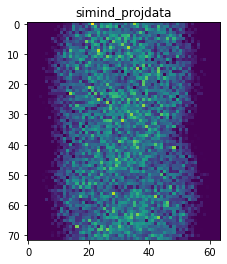

In [10]:
simind_projdata =  stir.ProjData.read_from_file("output_tot_w1.hs")

slice = simind_projdata.get_num_sinograms()//2
plot_show_save(simind_projdata, "simind_projdata", slice)

OK, so now we have our projection data in a format that SIRF likes, we can go about reconstructing the data.

In order to do this we first need to create our acqusition model matrix

In [11]:
acq_model_matrix = stir.ProjMatrixByBinSPECTUB() # create a SPECT porjection matrix object
acq_model_matrix.set_keep_all_views_in_cache(False) # This keeps views in memory for a speed improvement
acq_model_matrix.set_resolution_model(0.1,0.1) # Set a resolution model (just a guess!)
acq_model_matrix.set_up(simind_projdata.get_proj_data_info(), image)


INFO: 3D PSF Correction. Parallel geometry

Parameters of SPECT UB matrix: (in cm)
Image grid side row: 64	col: 64	transverse voxel_size: 0.4
Number of slices: 64	slice_thickness: 0.4
Number of bins: 64	bin size: 0.4	axial size: 0.4
Number of angles: 72	Angle increment: -5	First angle: 90
Number of subsets: 72
Rotation radii: {25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25}
Minimum weight: 0


INFO: Done estimating size of matrix. Execution (CPU) time 0.36 s 


In [12]:
projector = stir.ProjectorByBinPairUsingProjMatrixByBin(acq_model_matrix)
projector.set_up(simind_projdata.get_proj_data_info(), image)

<Swig Object of type 'stir::Succeeded *' at 0x7f0951df9a70>


INFO: Processing view 0 of segment 0

INFO: Computing matrix elements for view 0

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.06 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.09 (s)

INFO: Processing view 1 of segment 0

INFO: Computing matrix elements for view 1

INFO: total number of non-zero weights in this view: 2932928, estimated size: 28.3612 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 2 of segment 0

INFO: Computing matrix elements for view 2

INFO: total number of non-zero weights in this view: 2907722, estimated size: 28.1208 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 3 of segment 0

INFO: Computing matrix elements for view 3

INFO:

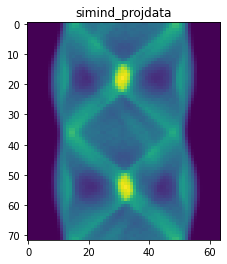

In [13]:
stir_projdata = stir.ProjDataInMemory(simind_projdata.get_exam_info(),
                                simind_projdata.get_proj_data_info())

projector.get_forward_projector().forward_project(stir_projdata, image)

slice = simind_projdata.get_num_sinograms()//2
plot_show_save(stir_projdata, "simind_projdata", slice)

And we can now backproject the data to get a rough idea of how we've done


INFO: Processing view 0 of segment 0

INFO: Computing matrix elements for view 0

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.07 (s)

INFO: Processing view 1 of segment 0

INFO: Computing matrix elements for view 1

INFO: total number of non-zero weights in this view: 2932928, estimated size: 28.3612 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 2 of segment 0

INFO: Computing matrix elements for view 2

INFO: total number of non-zero weights in this view: 2907722, estimated size: 28.1208 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: Processing view 3 of segment 0

INFO: Computing matrix elements for view 3

INFO:

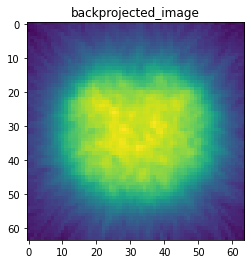

In [14]:
# create a dummy image to fill with out reconstructed image
target = image.get_empty_copy()
target.fill(1)

projector.get_back_projector().back_project(target, simind_projdata)
slice = target.get_lengths()[1]//2 # middle slice
plot_show_save(target, "backprojected_image", slice = slice)

We'll now use OSEM to reconstruct a nicer image.
First, we'll set up an objective function using out simind data and the projector we've just made from

Then we'll set up a reconstructor object with this objective function.

In [15]:
# create our objective function
obj_function = stir.PoissonLogLikelihoodWithLinearModelForMeanAndProjData3DFloat()
obj_function.set_proj_data_sptr(simind_projdata)
obj_function.set_projector_pair_sptr(projector)

# and now our reconstruction object
recon = stir.OSMAPOSLReconstruction3DFloat()
recon.set_objective_function(obj_function)
recon.set_num_subsets(9) # This needs to be a divisor of the number of projections (72)
recon.set_num_subiterations(9) # we'll go through the subiterations on ce
recon.set_max_num_full_iterations(1)

In [16]:
# create a dummy image to fill with out reconstructed image
target = image.get_empty_copy()
target.fill(1)

# and reconstruct
recon.set_up(target)
s = recon.reconstruct(target)


INFO: (subset)sensitivity filename(s) not set so I will compute the (subset)sensitivities

INFO: Computing sensitivity

INFO: calculating segment_num: 0, view_num: 0

INFO: Computing matrix elements for view 0

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.06 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.09 (s)

INFO: calculating segment_num: 0, view_num: 9

INFO: Computing matrix elements for view 9

INFO: total number of non-zero weights in this view: 2725146, estimated size: 26.3796 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.07 (s)

INFO: calculating segment_num: 0, view_num: 18

INFO: Computing matrix elements for view 18

INFO: total number of non-zero weights in this view: 3351136, estimated size: 32.3495 MB

INFO: Weight matrix calculation done. time 0.06 (s)

INFO: Total time 

Total CPU Time 6.16secs


ing to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: calculating segment_num: 0, view_num: 20

INFO: Computing matrix elements for view 20

INFO: total number of non-zero weights in this view: 2907722, estimated size: 28.1208 MB

INFO: Weight matrix calculation done. time 0.05 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.07 (s)

INFO: calculating segment_num: 0, view_num: 29

INFO: Computing matrix elements for view 29

INFO: total number of non-zero weights in this view: 2751988, estimated size: 26.6356 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: calculating segment_num: 0, view_num: 38

INFO: Computing matrix elements for view 38

INFO: total number of non-zero weights in this view: 2907722, estimated size: 28.1208 MB

INFO: Weight matrix calculation done. time 0.04 (s)

INFO: Total time after transfering to ProjMatrixElemsForOneBin. time 0.06 (s)

INFO: c

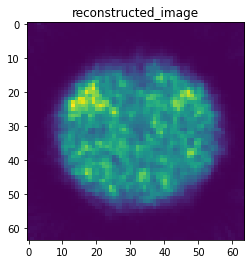

In [17]:
slice = stir_projdata.get_num_sinograms()//2
# The recpnstructed image
plot_show_save((target), "reconstructed_image", slice = slice)

In [18]:
### delete any rogue projections from the reconstruction
import glob
import os

for f in glob.glob("tmp*"):
    os.remove(f)
    
subprocess.run(["sh", os.path.join("..", "scripts", "remove_generated_files.sh")])

CompletedProcess(args=['sh', '../scripts/remove_generated_files.sh'], returncode=0)